<KeysViewHDF5 ['a_test', 'a_train', 't_mesh', 'u_test', 'u_train', 'x_mesh']>
torch.Size([100, 1])
torch.Size([128, 1])
torch.Size([200, 128])
torch.Size([200, 100, 128])
torch.Size([1000, 128])
torch.Size([1000, 100, 128])


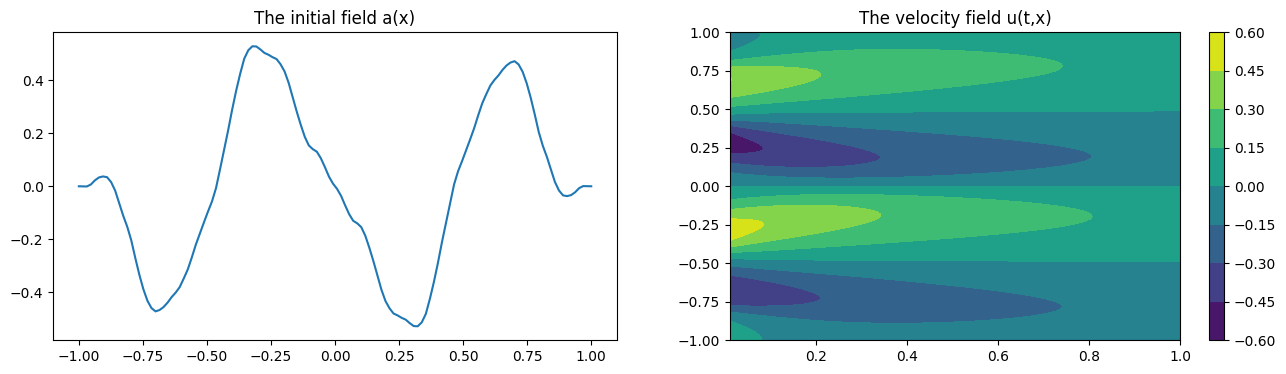

128
torch.Size([1000, 128])
torch.Size([1000, 12800])
torch.Size([200, 12800])


In [4]:
import numpy as np
import h5py
import torch
import matplotlib.pyplot as plt
dtype = torch.float32
device='cuda'
######################################
# Load training data

import os
os.chdir('/kaggle/input/dno4pdes')
######################################
with h5py.File('TrafficFlow.h5', 'r') as file:
    print(file.keys())
    t_mesh = torch.tensor(np.array(file['t_mesh']), dtype=dtype)
    x_mesh = torch.tensor(np.array(file['x_mesh']), dtype=dtype)
    a_test = torch.tensor(np.array(file['a_test']), dtype=dtype)
    u_test = torch.tensor(np.array(file['u_test']), dtype=dtype)
    a_train = torch.tensor(np.array(file['a_train']), dtype=dtype)
    u_train = torch.tensor(np.array(file['u_train']), dtype=dtype)
    #
    X, T = np.meshgrid(x_mesh, t_mesh)
#
print(t_mesh.shape)
print(x_mesh.shape)
print(a_test.shape)
print(u_test.shape)
print(a_train.shape)
print(u_train.shape)
#################################
inx = 1
fig, axes = plt.subplots(1,2, figsize=(16,4))
#
cntr = axes[0].plot(x_mesh, a_train[1])
axes[0].set_title('The initial field a(x)')
#
cntr = axes[1].contourf(T, X, u_train[inx])
axes[1].set_title('The velocity field u(t,x)')
plt.colorbar(cntr)
#
plt.show()

print(len(x_mesh))
print(a_train.shape)
u_train=u_train.view(u_train.shape[0], -1)
u_test=u_test.view(u_test.shape[0], -1)
print(u_train.shape)
print(u_test.shape)



In [83]:
import torch.nn as nn

# create the trunk network
ncx= len(x_mesh)
nct= len(t_mesh)
t_in = t_mesh
x_in = x_mesh

x_cor=np.repeat(x_in,nct,axis=1)
t_cor=np.repeat(t_in,ncx,axis=1).T
xt_train=np.vstack((x_cor.flatten(),t_cor.flatten())).T
#print(xt_in)

xt_train = torch.tensor(xt_train, dtype=dtype)
print('Size of collocation points:', xt_train.shape)

#
class DeepONet(nn.Module):
    
    def __init__(self, layers_trunk, layers_branch, branch_type=None):
        super(DeepONet, self).__init__()
        # The trunk network
        self.activation_trunk = nn.ReLU()
        self.trunk_net(layers_trunk)
        
        # The branch network
        self.activation_branch = nn.ReLU()
        if branch_type=='cnn':
            self.branch_net_cnn(layers_branch)
        else:
            self.branch_net_mlp(layers_branch)
            
        # The bias term
        self.bias = torch.nn.Parameter(torch.tensor(0.0, dtype=dtype))

    def branch_net_mlp(self, layers_branch):  #multi layer perceptron
        '''The branch network (MLP network)'''
        # Network Sequential
        net = []
        hidden_in = layers_branch[0]
        for hidden in layers_branch[1:]:
            net.append(nn.Linear(hidden_in, hidden, dtype=dtype))
            net.append(self.activation_branch)
            hidden_in = hidden
        self.branch = nn.Sequential(*net)

    def branch_net_cnn(self, layers_barnch):
        '''The branch network (CNN network)'''
        # Network Sequential
        net = []
        hidden_in = layers_barnch[0]
        for hidden in layers_barnch[1:]:
            net.append(nn.Conv2d(hidden_in, hidden, kernel_size=(5,5), 
                                 stride=2, dtype=dtype))
            net.append(self.activation_branch)
            hidden_in =  hidden 
        self.branch = nn.Sequential(*net)
        
    def trunk_net(self, layers_trunk):
        '''The trunk network'''
        # Network Sequential
        net = []
        hidden_in = layers_trunk[0]
        for hidden in layers_trunk[1:]:
            net.append(nn.Linear(hidden_in, hidden, dtype=dtype))
            net.append(self.activation_trunk)
            hidden_in = hidden
        self.trunk = nn.Sequential(*net)
        
    def forward(self, xt, a):
        ''' 
        Input:
            xt: size(mesh_size, xt_size)
            a: size(batch_size, a_size)
        '''
        # size(mesh_size, x_size) -> size(mesh_size, p)
        t = self.trunk(xt)
        # size(batch_size, a_size) -> size(batch_size, p)
        b = self.branch(a)
        #
        #element-wise product
        output = torch.einsum("bp,mp->bp", b, t) + self.bias
        return output
#
layers_trunk = [xt_train.shape[-1],128,256,512,12800]
#print(xt_train.shape[-1])

layers_branch = [a_train.shape[-1],128,256,512,12800]
#print(a_train.shape[-1])
#
model_u = DeepONet(layers_trunk, layers_branch).to(device)
#
from torchsummary import summary
summary(model_u, [(2,), (128,)], device='cuda')


Size of collocation points: torch.Size([12800, 2])
2
128
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             384
              ReLU-2                  [-1, 128]               0
              ReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 256]          33,024
              ReLU-5                  [-1, 256]               0
              ReLU-6                  [-1, 256]               0
            Linear-7                  [-1, 512]         131,584
              ReLU-8                  [-1, 512]               0
              ReLU-9                  [-1, 512]               0
           Linear-10                [-1, 12800]       6,566,400
             ReLU-11                [-1, 12800]               0
             ReLU-12                [-1, 12800]               0
           Linear-13                  [-1, 128

In [84]:
class LossClass(object):

    def __init__(self, u_model):
        self.device = device
        self.u_model = u_model 
        self.getLoss = torch.nn.MSELoss()
    
    def loss_data(self, a_batch, u_batch):
        '''loss term'''
        xt, a, u = xt_train.to(self.device), a_batch.to(self.device), u_batch.to(self.device)
        #
        u_pred = self.u_model(xt, a)
        #print(u_pred.shape)
        #print(u.tensor.view(tensor.shape[0], -1).shape)
        #u=u.view(u.shape[0], -1)
        #print(u.shape)
        loss = self.getLoss(u, u_pred)
        
        return loss 

    def get_error(self, a_test, u_test):
        '''Compute the L^2 relative error when testing dataset is given'''
        xt=xt_train.to(self.device)
        a_test=a_test.to(self.device)
        u_test = u_test.to(self.device)
        u_pred = self.u_model(xt,a_test)
        
        l2 = torch.norm((u_pred-u_test),2,1) / torch.norm((u_test),2,1)
        return torch.mean(l2)

In [117]:
from torch.utils.data import Dataset, DataLoader
############# Define your own dataset 
class MyDataset(Dataset):

    def __init__(self, a:torch.tensor, u:torch.tensor):
        '''
        Input:
            a: size(batch_size, a_size)
            u: size(batch_size, u_size)
        '''
        self.a = a 
        self.u = u
    
    def __getitem__(self, index):
        return self.a[index], self.u[index]

    def __len__(self):
        return self.a.shape[0]
        
##############
train_loader = DataLoader(MyDataset(a_train, u_train), batch_size=500, shuffle=True)
for a_batch, u_batch in train_loader:
    print('a_batch shape:', a_batch.shape, 'u_batch shape:', u_batch.shape)

a_batch shape: torch.Size([500, 128]) u_batch shape: torch.Size([500, 12800])
a_batch shape: torch.Size([500, 128]) u_batch shape: torch.Size([500, 12800])


In [85]:
error_list= []
loss_list = []

# batch size 1000(1)->500(2)->250(3)->200(4,5)->100(6)->250(7)->200(8)->200(9)->500(10)
# epochs 200->300->300->300->300->200->500->300->400->200 (total of 2800 epochs)

In [118]:
from tqdm import trange
import time
############ Training setups
epochs = 200
# more training epochs: the weird thing is that if you keep training with smaller epoch with more times,the decrease rate goes faster 
# nevertheless, overall the model shows that it evetually decrease to acceptable range


lr = 1e-3
optimizer = torch.optim.Adam(params=model_u.parameters(), lr=lr, weight_decay=1e-4)
torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/4), gamma=0.5)
############ The training process
t0 = time.time()
for epoch in trange(epochs):
    loss = 0.
    for a_batch, u_batch in train_loader:
        lossClass = LossClass(model_u)
        loss_train = lossClass.loss_data(a_batch, u_batch)
        #
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        #
        loss += loss_train
    scheduler.step()  # Adjust learning rate
    #
    loss = loss/len(train_loader)
    loss_list.append(loss.item())
    
    with torch.no_grad():
        error = lossClass.get_error(a_test, u_test)
        error_list.append(error.item())
        
    if (epoch+1)%100==0:
        print(f'Epoch:{epoch}, The loss is:{loss.item()}')
print('The consuming time is:', time.time()-t0)

 50%|█████     | 100/200 [00:34<00:34,  2.90it/s]

Epoch:99, The loss is:0.0001775870332494378


100%|██████████| 200/200 [01:09<00:00,  2.89it/s]

Epoch:199, The loss is:0.00016710482304915786
The consuming time is: 69.18678331375122


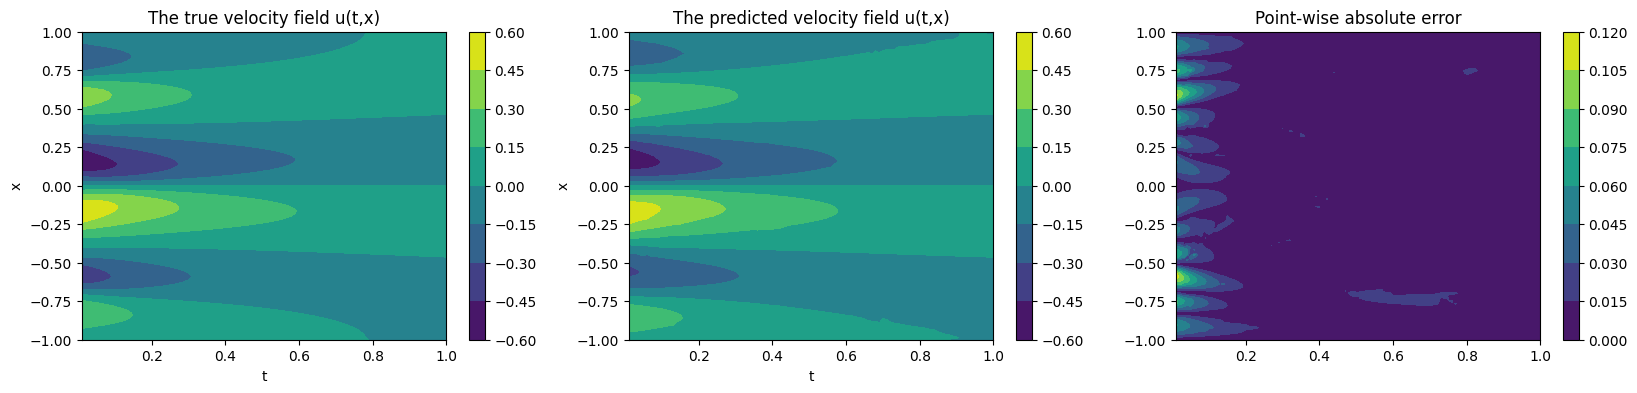

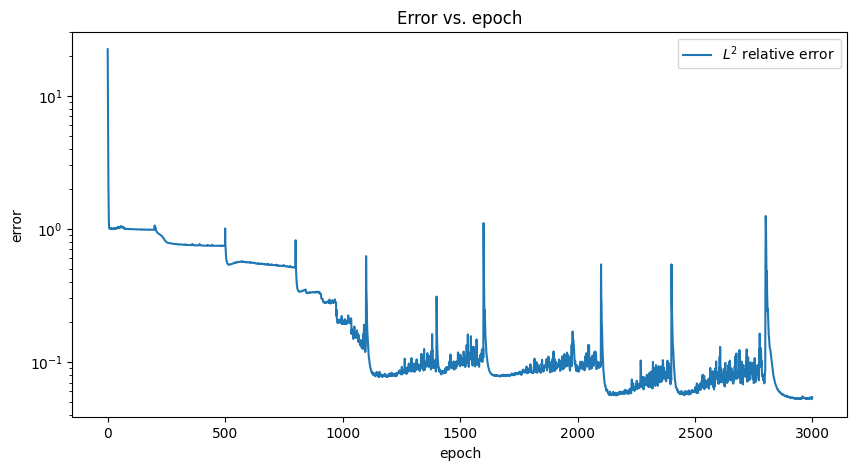

The final L^2 relative error is:0.054178714752197266


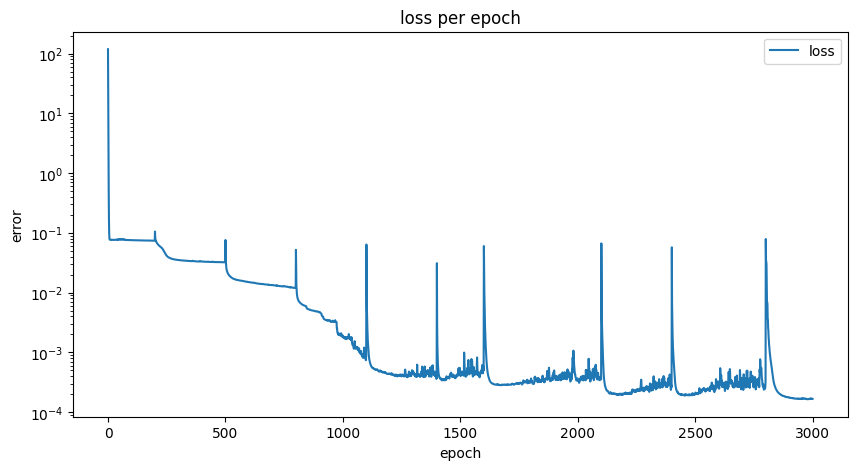

In [121]:
#######################################
# Visualize the prediction and truth u
#######################################
u_test_pred = model_u(xt_train.to(device), a_test.to(device)).detach().cpu()
u_true = u_test[0]
u_pred = u_test_pred[0]
#
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
#
cntr1 = axes[0].contourf(T, X, u_true.ravel().reshape(100,128))
axes[0].set_title('The true velocity field u(t,x)')
axes[0].set_xlabel('t')
axes[0].set_ylabel('x')
plt.colorbar(cntr1)

cntr2= axes[1].contourf(T, X, u_pred.reshape(100,128))
axes[1].set_title('The predicted velocity field u(t,x)')
axes[1].set_xlabel('t')
axes[1].set_ylabel('x')
plt.colorbar(cntr2)


cntr3 = axes[2].contourf(T, X, np.abs(u_true-u_pred).reshape(100,128))
axes[2].set_title('Point-wise absolute error')
plt.colorbar(cntr3)

plt.show()


fig,ax=plt.subplots(1,1, figsize=(10,5))
ax.semilogy(error_list, label='$L^2$ relative error')
ax.set_title('Error vs. epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('error')
ax.legend()

plt.show()


fig,ax=plt.subplots(1,1, figsize=(10,5))
ax.semilogy(loss_list, label='loss')
ax.set_title('loss per epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('error')
ax.legend()

print(f'The final L^2 relative error is:{error}')


In [122]:
#######save the model
print("The state dict keys: \n\n", model_u.state_dict().keys())

The state dict keys: 

 odict_keys(['bias', 'trunk.0.weight', 'trunk.0.bias', 'trunk.2.weight', 'trunk.2.bias', 'trunk.4.weight', 'trunk.4.bias', 'trunk.6.weight', 'trunk.6.bias', 'branch.0.weight', 'branch.0.bias', 'branch.2.weight', 'branch.2.bias', 'branch.4.weight', 'branch.4.bias', 'branch.6.weight', 'branch.6.bias'])


In [126]:
checkpoint = {'model': model_u,
              'state_dict': model_u.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, '/kaggle/working/model_u.pth')

In [131]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model

In [132]:
model = load_checkpoint('/kaggle/working/model_u.pth')
print(model)

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.DeepONet was not an allowed global by default. Please use `torch.serialization.add_safe_globals([DeepONet])` or the `torch.serialization.safe_globals([DeepONet])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.